# 02-glioma-growth-synthseg.ipynb

Using the `glioma-growth`conda environment

Arvid Lundervold 


Last updated: 2024-11-06

### The LUMIERE dataset

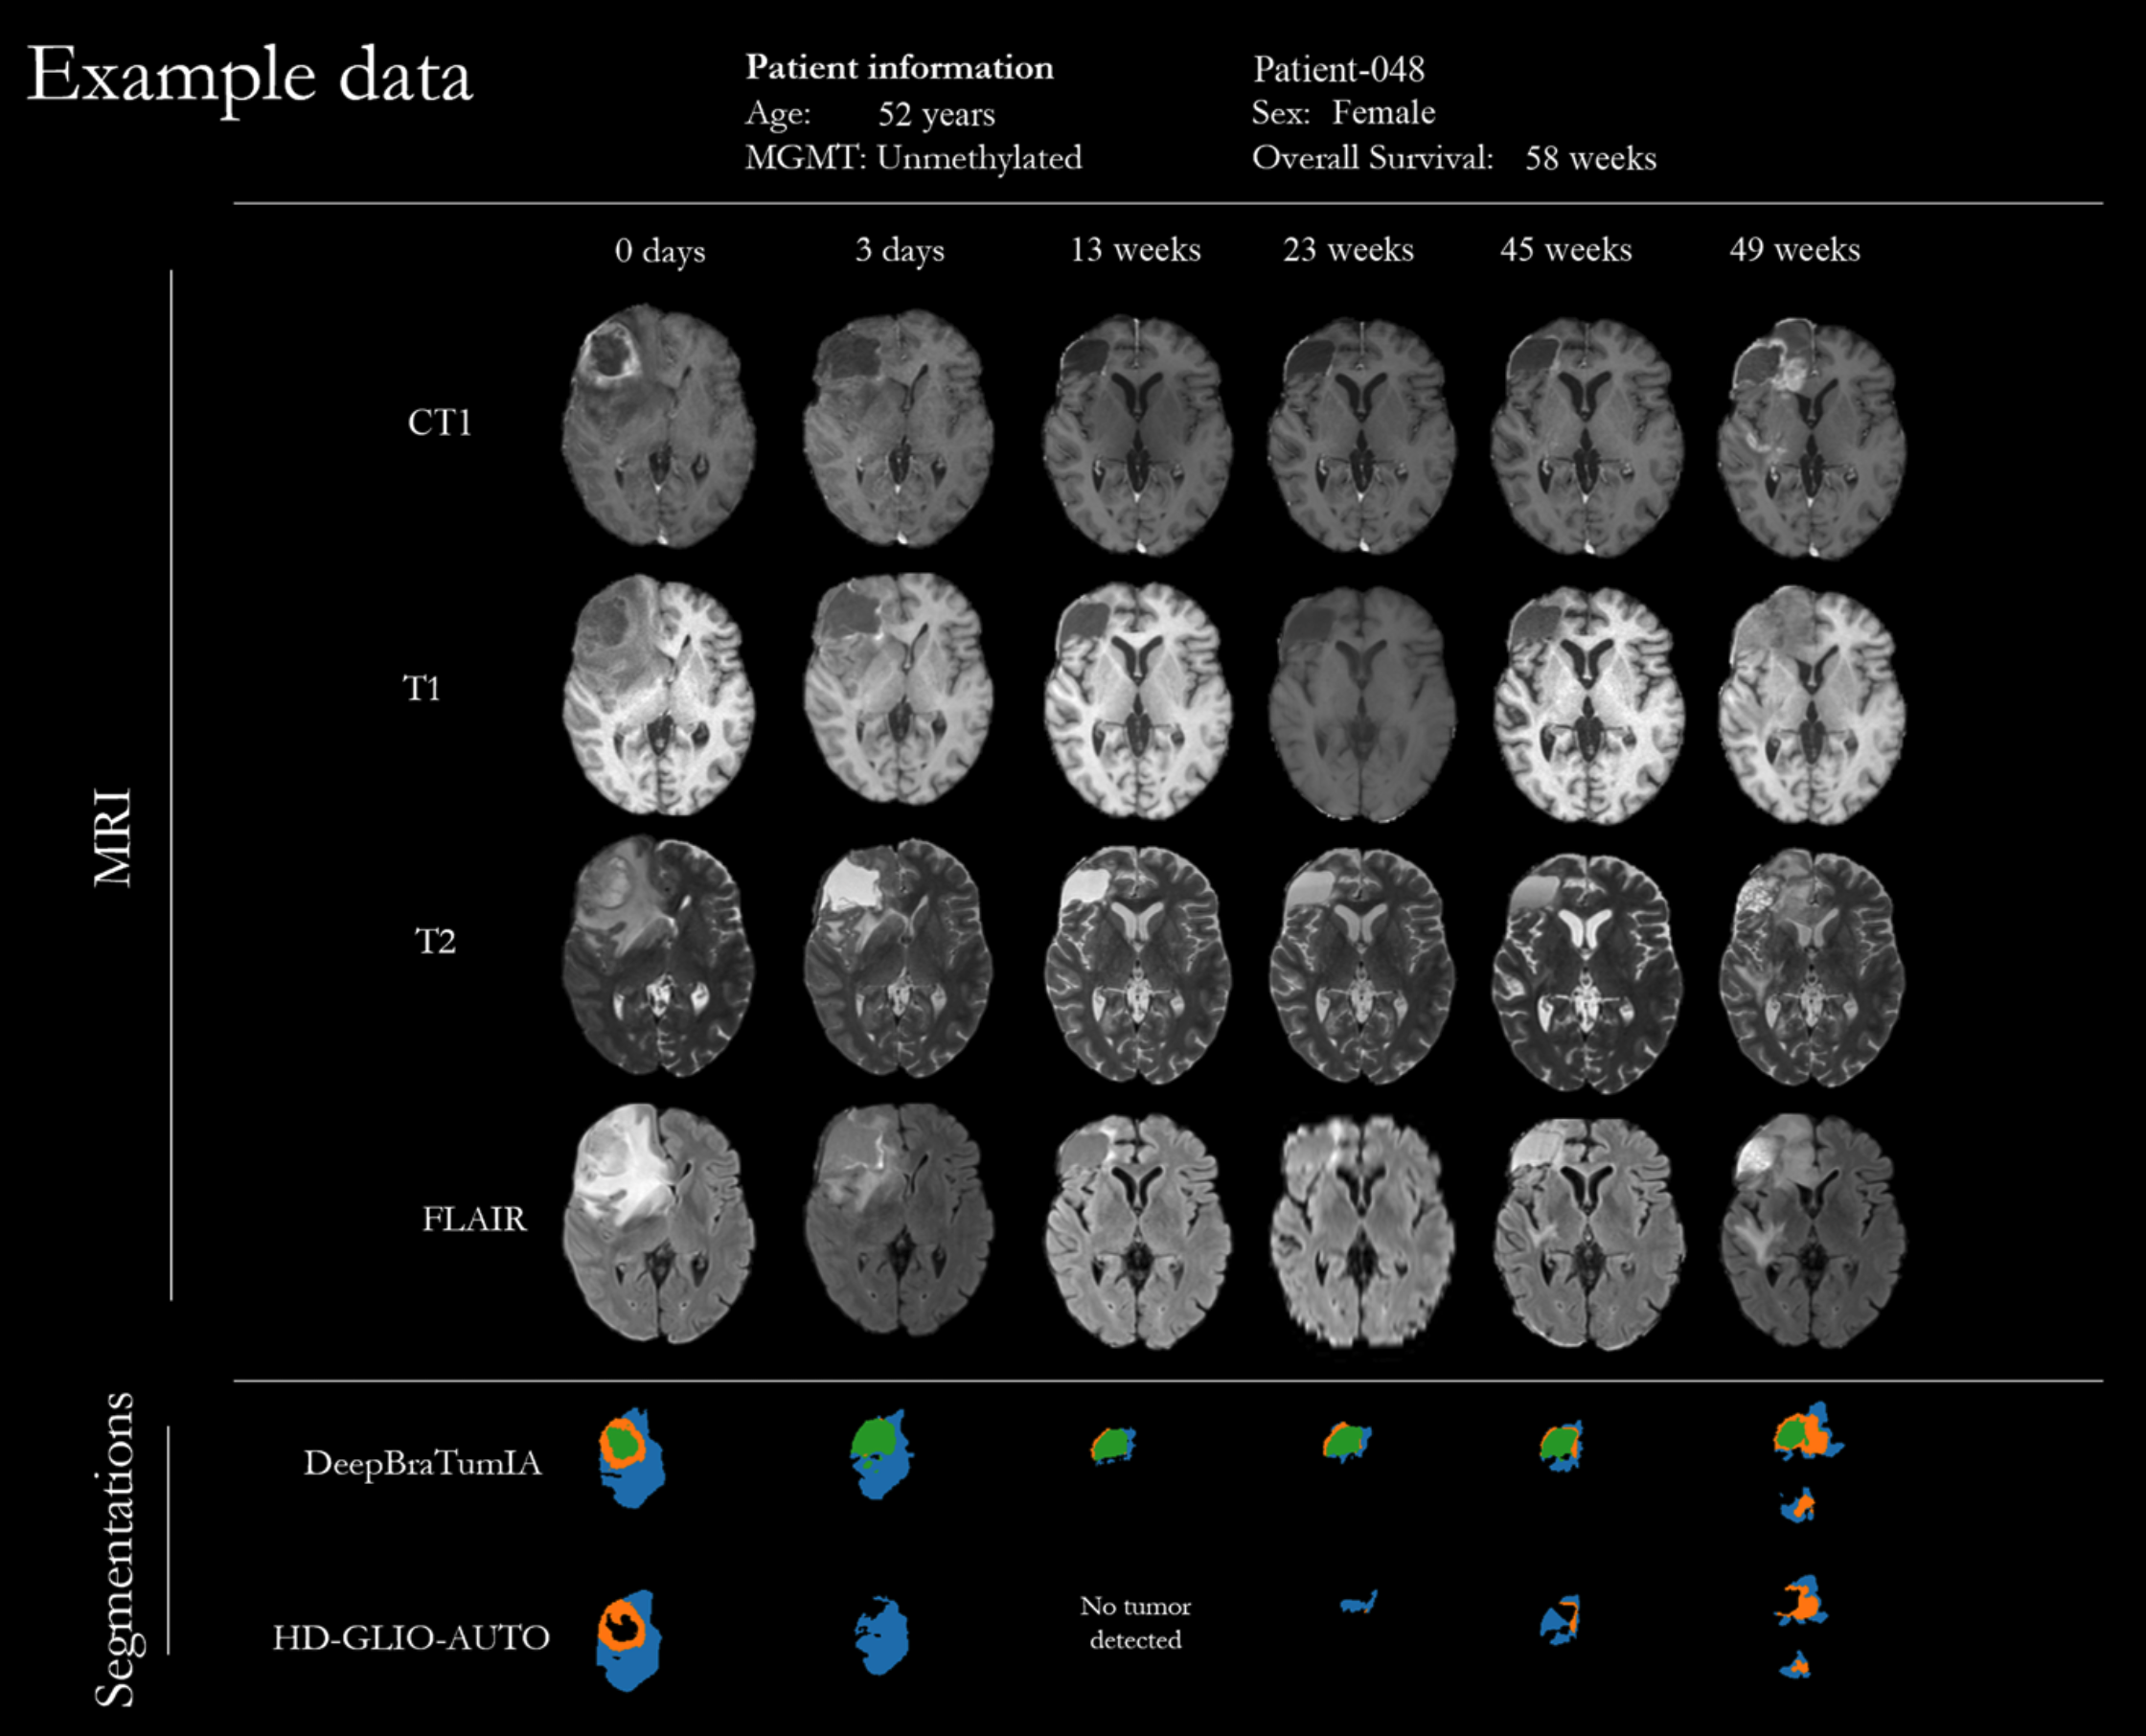

In [1]:
import os
curr_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/notebooks"
os.chdir(curr_dir)

from IPython.display import Image, display
display(Image(filename='../assets/LUMIERE-Patient-048-1.png', width=800))

In [2]:
# Import libraries
import os
import sys
import pathlib
import platform
import re
import glob
import shutil
import subprocess
import warnings
from itertools import repeat
import json
import numpy as np
import pandas as pd

home = os.path.expanduser('~')

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
    TREE = '/usr/local/bin/tree -L 1'          # MacOS (brew install tree)
    fshome = '/Applications/freesurfer/7.4.1'
    MacOS = True
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
    TREE = '/usr/bin/tree -L 4'
    fshome = '/usr/local/freesurfer/7.4.1'
    MacOS = False
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 24.1.0: Thu Oct 10 21:02:27 PDT 2024; root:xnu-11215.41.3~2/RELEASE_X86_64)


**Copy LUMIERE Patient-048 HD-GLIO segmented and registered data to the `LUMIERE-Patient-048-reg` directory**

In [4]:
tp = ['week-000-1', 'week-000-2', 'week-013', 'week-023', 'week-045', 'week-049']
all_chns = ['T1', 'CT1', 'T2', 'FLAIR']

In [5]:
def get_subjs(exam_dir):
    all_dirs = sorted(glob.glob(f'{exam_dir}/*'))    # exams from local recordings
    subjs = [ os.path.basename(d) for d in all_dirs]
    n = len(subjs)

    print(f'{n} examinations:')
    print('[')
    for i, sub in enumerate(subjs):
      print(f"'{sub}',")
    print(']')
    return subjs


In [6]:
for t in tp:
    exam_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/{t}"
    print(f'exam_dir: {exam_dir}')
    subjs = get_subjs(exam_dir)

exam_dir: /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-000-1
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-000-2
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-013
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-023
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-045
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz'

## Running [SynthSeg](https://surfer.nmr.mgh.harvard.edu/fswiki/SynthSeg) on the T1 exams ...



_**cursor** claude-3.5-sonnet_ "Explain synthseg"



SynthSeg is a deep learning-based tool for brain MRI segmentation. Here's a detailed explanation:

1. **What is SynthSeg?**
- Part of FreeSurfer toolkit
- Robust brain segmentation tool
- Works on T1-weighted MRI
- Domain-adaptive deep learning approach

2. **Key Features**
`````python
# Basic SynthSeg command
cmd = [
    'mri_synthseg',
    '--i', 'input_t1.nii.gz',      # Input T1 MRI
    '--o', 'output_seg.nii.gz',    # Output segmentation
    '--robust',                    # Robust to pathologies
    '--parc'                       # Include parcellation
]
`````

3. **Segmentation Labels**
- Outputs ~100 anatomical labels
- Key structures include:
  - Gray matter regions
  - White matter regions
  - Subcortical structures
  - Ventricles
  - Cerebellum
  - Brainstem

4. **Common Options**
`````python
# Extended options
cmd = [
    'mri_synthseg',
    '--i', input_path,
    '--o', output_path,
    '--robust',                    # More robust to pathologies
    '--parc',                      # Run parcellation
    '--vol', volume_path,          # Output volumes
    '--qc', qc_path,              # Quality control
    '--threads', '4',             # Multi-threading
    '--cpu',                      # Force CPU usage
    '--fast',                     # Faster processing
]
`````

5. **Output Types**

a) **Segmentation Map**
```python
# Default output
--o segmentation.nii.gz
```
- 3D volume with integer labels
- Each label corresponds to brain structure

b) **Volume Statistics**
```python
# Volume computation
--vol stats.csv
```
- Structure volumes in mm³
- Percentage of total volume

c) **Quality Control**
```python
# QC metrics
--qc qc_folder/
```
- Segmentation quality metrics
- Visualization outputs

6. **Use Cases**

a) **Clinical Applications**
- Brain structure analysis
- Disease monitoring
- Surgical planning
- Research studies

b) **Research Applications**
- Morphometric studies
- Longitudinal analysis
- Group comparisons
- Atlas building

7. **Example Workflow**
`````python
def run_synthseg_analysis(t1_path):
    """Complete SynthSeg analysis workflow."""
    import subprocess
    from pathlib import Path
    
    # Setup paths
    base_dir = Path(t1_path).parent
    output_dir = base_dir / 'synthseg'
    output_dir.mkdir(exist_ok=True)
    
    # Run SynthSeg
    cmd = [
        'mri_synthseg',
        '--i', str(t1_path),
        '--o', str(output_dir / 'seg.nii.gz'),
        '--robust',
        '--parc',
        '--vol', str(output_dir / 'volumes.csv'),
        '--qc', str(output_dir / 'qc')
    ]
    
    subprocess.run(cmd, check=True)
`````

8. **Advantages**
- Domain-adaptive (works on different scanners)
- Robust to pathologies
- No training required
- Fast processing
- Consistent results

9. **Best Practices**

a) **Input Data**
- Use high-quality T1 images
- Check for artifacts
- Consistent orientation

b) **Processing**
```python
# Recommended settings for clinical data
cmd = [
    'mri_synthseg',
    '--i', input_path,
    '--o', output_path,
    '--robust',      # Important for pathological cases
    '--parc',        # Full parcellation
    '--threads', '4' # Adjust based on system
]
```

c) **Quality Control**
- Always check QC outputs
- Verify key structures
- Compare with manual segmentation if possible

10. **Integration Example**
`````python
def process_longitudinal_data(subject_dir, timepoints):
    """Process longitudinal T1 scans with SynthSeg."""
    results = {}
    
    for tp in timepoints:
        # Process each timepoint
        t1_path = f"{subject_dir}/{tp}/T1.nii.gz"
        out_path = f"{subject_dir}/{tp}/synthseg.nii.gz"
        vol_path = f"{subject_dir}/{tp}/volumes.csv"
        
        cmd = [
            'mri_synthseg',
            '--i', t1_path,
            '--o', out_path,
            '--vol', vol_path,
            '--robust',
            '--parc'
        ]
        
        subprocess.run(cmd, check=True)
        
        # Store results
        results[tp] = {
            'segmentation': out_path,
            'volumes': vol_path
        }
    
    return results
`````

Would you like me to elaborate on any specific aspect of SynthSeg or provide more detailed examples for specific use cases?

-----

_**cursor** (with claude-3.5-sonnet)_ "Explain the `--robust` and `--parc` flags"


Let me explain the `--robust` and `--parc` flags in SynthSeg in detail:

1. **--robust Flag**
``````python
# Using robust flag
cmd = [
    'mri_synthseg',
    '--i', input_t1,
    '--o', output_seg,
    '--robust'  # Makes segmentation more robust to pathologies
]
``````

**Purpose:**
- Makes segmentation more robust to pathological cases
- Handles abnormal anatomy better
- Useful for:
  - Tumor cases
  - Lesions
  - Post-surgical cases
  - Abnormal ventricle size
  - Brain deformations

**How it works:**
- Uses additional training data augmentation
- More tolerant to intensity variations
- Better handles anatomical deviations
- Slower but more accurate in pathological cases

2. **--parc Flag**
``````python
# Using parcellation flag
cmd = [
    'mri_synthseg',
    '--i', input_t1,
    '--o', output_seg,
    '--parc'  # Enables detailed parcellation
]
``````

**Purpose:**
- Enables detailed brain parcellation
- Produces FreeSurfer-like segmentation
- Outputs ~100 anatomical labels including:

**Cortical Structures:**
- Frontal lobe regions
- Temporal lobe regions
- Parietal lobe regions
- Occipital lobe regions
- Cingulate regions

**Subcortical Structures:**
- Thalamus
- Caudate
- Putamen
- Pallidum
- Hippocampus
- Amygdala
- Accumbens

**Other Structures:**
- White matter regions
- Ventricles
- Cerebellum
- Brainstem
- CSF spaces

3. **Combined Usage**
``````python
def run_detailed_synthseg(t1_path, output_dir):
    """Run SynthSeg with both robust and parcellation options."""
    cmd = [
        'mri_synthseg',
        '--i', str(t1_path),
        '--o', str(output_dir / 'seg.nii.gz'),
        '--robust',     # Handle pathologies
        '--parc',       # Detailed parcellation
        '--vol', str(output_dir / 'volumes.csv'),  # Volume statistics
        '--qc', str(output_dir / 'qc')            # Quality control
    ]
    
    # Run command
    subprocess.run(cmd, check=True)
    
    # Optional: Print volumes
    import pandas as pd
    volumes = pd.read_csv(output_dir / 'volumes.csv')
    print("Structure volumes (mm³):")
    print(volumes)
``````

4. **Use Cases**

a) **Clinical Research:**
``````python
# For clinical cases with pathology
cmd = [
    'mri_synthseg',
    '--i', input_path,
    '--o', output_path,
    '--robust',  # Important for clinical cases
    '--parc',    # Get detailed segmentation
    '--vol'      # Get volume measurements
]
``````

b) **Longitudinal Studies:**
``````python
# For tracking changes over time
cmd = [
    'mri_synthseg',
    '--i', timepoint_path,
    '--o', output_path,
    '--robust',  # Handle potential changes
    '--parc',    # Track regional changes
    '--qc'       # Quality control important for longitudinal
]
``````

5. **Performance Considerations**

When using both flags:
``````python
# Typical processing times
cmd = [
    'mri_synthseg',
    '--i', input_path,
    '--o', output_path,
    '--robust',     # Increases processing time
    '--parc',       # Increases processing time
    '--threads', '4' # Compensate with parallelization
]
``````

- `--robust`: Increases processing time by ~2x
- `--parc`: Increases processing time by ~1.5x
- Combined: Expect ~3x longer processing time

6. **Best Practices**

``````python
def optimal_synthseg_settings(t1_path, is_pathological=True):
    """Choose optimal SynthSeg settings based on case."""
    cmd = ['mri_synthseg', '--i', t1_path]
    
    if is_pathological:
        cmd.append('--robust')  # Add for pathological cases
    
    if need_detailed_regions:
        cmd.append('--parc')   # Add for detailed parcellation
    
    # Always good to have
    cmd.extend([
        '--vol',     # Get volumes
        '--qc',      # Quality control
        '--threads', '4'  # Parallel processing
    ])
    
    return cmd
``````

Remember:
- Use `--robust` when dealing with pathological cases
- Use `--parc` when detailed regional segmentation is needed
- Both flags increase processing time
- Consider computational resources when using both flags
- Always check QC outputs for validation

Would you like me to elaborate on any specific aspect of these flags or provide more examples?

----

_**cursor** (with claude-3.5-sonnet)_ "Please elaborate on SynthSeg and longitudinal evaluation of glioma progression using --robust and --parc"



Here's a detailed explanation of using SynthSeg for longitudinal glioma evaluation:

1. **Longitudinal Processing Setup**
```python
def setup_longitudinal_synthseg(base_dir, timepoints):
    """Setup longitudinal SynthSeg analysis for glioma progression."""
    
    output_structure = {
        'segmentations': Path(base_dir) / 'synthseg_results' / 'segmentations',
        'volumes': Path(base_dir) / 'synthseg_results' / 'volumes',
        'qc': Path(base_dir) / 'synthseg_results' / 'qc'
    }
    
    # Create directories
    for dir_path in output_structure.values():
        dir_path.mkdir(parents=True, exist_ok=True)
        
    return output_structure
```

2. **Processing Pipeline**
```python
def process_longitudinal_glioma(base_dir, timepoints):
    """Process longitudinal T1 scans for glioma evaluation."""
    
    # Setup directories
    dirs = setup_longitudinal_synthseg(base_dir, timepoints)
    
    results = {}
    for tp in timepoints:
        # Input/output paths
        t1_path = Path(base_dir) / tp / 'T1.nii.gz'
        seg_path = dirs['segmentations'] / f'{tp}_synthseg.nii.gz'
        vol_path = dirs['volumes'] / f'{tp}_volumes.csv'
        qc_path = dirs['qc'] / tp
        
        # Run SynthSeg with both flags
        cmd = [
            'mri_synthseg',
            '--i', str(t1_path),
            '--o', str(seg_path),
            '--robust',     # Important for tumor cases
            '--parc',       # Get detailed parcellation
            '--vol', str(vol_path),
            '--qc', str(qc_path),
            '--threads', '4'
        ]
        
        subprocess.run(cmd, check=True)
        results[tp] = {
            'segmentation': seg_path,
            'volumes': vol_path,
            'qc': qc_path
        }
    
    return results
```

3. **Volume Analysis**
```python
def analyze_volume_changes(results_dict, timepoints):
    """Analyze volume changes across timepoints."""
    import pandas as pd
    
    volumes_data = {}
    for tp in timepoints:
        df = pd.read_csv(results_dict[tp]['volumes'])
        volumes_data[tp] = df
    
    # Create longitudinal volume DataFrame
    vol_changes = pd.DataFrame({
        tp: data['Volume_mm3'] 
        for tp, data in volumes_data.items()
    })
    
    # Calculate percent changes
    baseline = vol_changes[timepoints[0]]
    for tp in timepoints[1:]:
        vol_changes[f'{tp}_pct_change'] = (
            (vol_changes[tp] - baseline) / baseline * 100
        )
    
    return vol_changes
```

4. **Quality Control Visualization**
```python
def visualize_longitudinal_results(base_dir, timepoints, results):
    """Visualize segmentation results across timepoints."""
    from nilearn import plotting
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, len(timepoints), figsize=(20, 8))
    
    for idx, tp in enumerate(timepoints):
        # Original T1
        t1_path = Path(base_dir) / tp / 'T1.nii.gz'
        plotting.plot_anat(
            t1_path, 
            title=f'{tp} - T1',
            axes=axes[0, idx]
        )
        
        # SynthSeg result
        seg_path = results[tp]['segmentation']
        plotting.plot_roi(
            seg_path,
            t1_path,
            title=f'{tp} - Segmentation',
            axes=axes[1, idx]
        )
    
    plt.tight_layout()
    return fig
```

5. **Region-Specific Analysis**
```python
def analyze_tumor_adjacent_regions(results_dict, timepoints):
    """Analyze changes in regions adjacent to tumor."""
    
    # Regions of interest near typical glioma locations
    roi_labels = {
        'White Matter': [2, 41],  # White matter regions
        'Gray Matter': [3, 42],   # Gray matter regions
        'Ventricles': [4, 43],    # Ventricles
        'Subcortical': [10, 49]   # Deep gray matter
    }
    
    # Track volumes over time
    roi_volumes = {roi: [] for roi in roi_labels}
    
    for tp in timepoints:
        seg = nib.load(results_dict[tp]['segmentation']).get_fdata()
        
        for roi, labels in roi_labels.items():
            volume = np.sum(np.isin(seg, labels))
            roi_volumes[roi].append(volume)
    
    return roi_volumes
```

6. **Complete Workflow Example**
```python
def run_glioma_progression_analysis(base_dir, timepoints):
    """Complete workflow for glioma progression analysis."""
    
    # 1. Process all timepoints
    results = process_longitudinal_glioma(base_dir, timepoints)
    
    # 2. Analyze volume changes
    volume_changes = analyze_volume_changes(results, timepoints)
    
    # 3. Analyze tumor-adjacent regions
    roi_volumes = analyze_tumor_adjacent_regions(results, timepoints)
    
    # 4. Generate visualizations
    fig = visualize_longitudinal_results(base_dir, timepoints, results)
    
    # 5. Save results
    output_dir = Path(base_dir) / 'analysis_results'
    output_dir.mkdir(exist_ok=True)
    
    volume_changes.to_csv(output_dir / 'volume_changes.csv')
    fig.savefig(output_dir / 'longitudinal_visualization.png')
    
    return {
        'volume_changes': volume_changes,
        'roi_volumes': roi_volumes,
        'visualization': fig,
        'segmentations': results
    }

# Example usage
base_dir = "/path/to/patient/data"
timepoints = ['week-000-1', 'week-000-2', 'week-013', 'week-023', 'week-045', 'week-049']
analysis_results = run_glioma_progression_analysis(base_dir, timepoints)
```

This comprehensive approach:
- Uses `--robust` for handling tumor-related anatomical changes
- Uses `--parc` for detailed regional analysis
- Tracks volume changes over time
- Analyzes tumor-adjacent regions
- Provides quality control visualizations
- Generates quantitative metrics for progression assessment

Would you like me to elaborate on any specific aspect or add additional functionality?

----

_**cursor** (with claude-3.5-sonnet)_ "Could you suggest a finer granularity of tumor adjacent regions?"


Here's a more detailed breakdown of tumor-adjacent regions for glioma analysis:

```python
def analyze_detailed_tumor_adjacent_regions(results_dict, timepoints):
    """Analyze changes in detailed regions adjacent to tumor."""
    
    # Detailed regions of interest near typical glioma locations
    roi_labels = {
        # White Matter Regions
        'Cerebral_WM_Left': [2],
        'Cerebral_WM_Right': [41],
        'WM_Hypointensities': [77],
        'Corpus_Callosum': [251, 252, 253, 254, 255],  # Different CC segments
        
        # Gray Matter Regions
        'Cortical_GM_Left': [3],
        'Cortical_GM_Right': [42],
        
        # Deep Gray Matter
        'Thalamus_Left': [10],
        'Thalamus_Right': [49],
        'Caudate_Left': [11],
        'Caudate_Right': [50],
        'Putamen_Left': [12],
        'Putamen_Right': [51],
        'Pallidum_Left': [13],
        'Pallidum_Right': [52],
        
        # Ventricles and CSF
        'Lateral_Ventricle_Left': [4],
        'Lateral_Ventricle_Right': [43],
        'Third_Ventricle': [14],
        'Fourth_Ventricle': [15],
        'CSF': [24],
        
        # Temporal Lobe Structures
        'Hippocampus_Left': [17],
        'Hippocampus_Right': [53],
        'Amygdala_Left': [18],
        'Amygdala_Right': [54],
        
        # Specific Cortical Regions
        'Frontal_Left': [1028],
        'Frontal_Right': [2028],
        'Parietal_Left': [1029],
        'Parietal_Right': [2029],
        'Temporal_Left': [1030],
        'Temporal_Right': [2030],
        'Occipital_Left': [1031],
        'Occipital_Right': [2031],
        
        # Additional Important Structures
        'Brainstem': [16],
        'Cerebellum_WM_Left': [7],
        'Cerebellum_WM_Right': [46],
        'Cerebellum_Cortex_Left': [8],
        'Cerebellum_Cortex_Right': [47]
    }
    
    # Track volumes and statistics over time
    region_stats = {roi: {
        'volumes': [],
        'mean_intensity': [],
        'std_intensity': [],
        'displacement': []  # If registration transforms available
    } for roi in roi_labels}
    
    for tp in timepoints:
        # Load segmentation and T1 image
        seg = nib.load(results_dict[tp]['segmentation']).get_fdata()
        t1 = nib.load(str(Path(results_dict[tp]['t1_path']))).get_fdata()
        
        for roi, labels in roi_labels.items():
            # Create mask for this ROI
            roi_mask = np.isin(seg, labels)
            
            # Calculate statistics
            region_stats[roi]['volumes'].append(np.sum(roi_mask))
            region_stats[roi]['mean_intensity'].append(
                np.mean(t1[roi_mask])
            )
            region_stats[roi]['std_intensity'].append(
                np.std(t1[roi_mask])
            )
            
            # Optional: Calculate displacement if transforms available
            if 'transform' in results_dict[tp]:
                displacement = calculate_displacement(
                    roi_mask, 
                    results_dict[tp]['transform']
                )
                region_stats[roi]['displacement'].append(displacement)
    
    return region_stats

def analyze_regional_relationships(region_stats, timepoints):
    """Analyze relationships between different regions over time."""
    import pandas as pd
    
    # Create time series for each metric
    volume_df = pd.DataFrame({
        roi: stats['volumes'] 
        for roi, stats in region_stats.items()
    }, index=timepoints)
    
    # Calculate relative changes
    baseline = volume_df.iloc[0]
    volume_changes = ((volume_df - baseline) / baseline) * 100
    
    # Analyze regional correlations
    correlations = volume_changes.corr()
    
    # Identify most affected regions
    max_changes = volume_changes.abs().max()
    
    return {
        'volume_changes': volume_changes,
        'correlations': correlations,
        'max_changes': max_changes
    }

def visualize_regional_changes(region_stats, timepoints):
    """Create detailed visualizations of regional changes."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Volume changes plot
    plt.figure(figsize=(15, 10))
    for roi, stats in region_stats.items():
        baseline = stats['volumes'][0]
        relative_changes = [(v - baseline) / baseline * 100 
                          for v in stats['volumes']]
        plt.plot(timepoints, relative_changes, label=roi, marker='o')
    
    plt.title('Regional Volume Changes Over Time')
    plt.xlabel('Timepoint')
    plt.ylabel('Percent Change from Baseline')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

# Example usage
def run_detailed_regional_analysis(base_dir, timepoints):
    """Run complete regional analysis workflow."""
    
    # Get SynthSeg results
    results = process_longitudinal_glioma(base_dir, timepoints)
    
    # Analyze detailed regions
    region_stats = analyze_detailed_tumor_adjacent_regions(results, timepoints)
    
    # Analyze relationships
    relationship_analysis = analyze_regional_relationships(region_stats, timepoints)
    
    # Create visualizations
    fig = visualize_regional_changes(region_stats, timepoints)
    
    return {
        'region_stats': region_stats,
        'relationships': relationship_analysis,
        'visualization': fig
    }
```

This enhanced analysis provides:
1. More detailed anatomical regions
2. Bilateral structure comparison
3. Specific cortical regions
4. Deep brain structures
5. White matter pathways
6. Ventricle system components
7. Additional metrics beyond volume
8. Regional relationships analysis
9. Detailed visualization options

Would you like me to elaborate on any specific aspect or add more regions/metrics?

----

_**cursor** (with claude-3.5-sonnet)_ "Use this to set up a complete pipeline for detailed glioma progression analysis. base_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg"


This pipeline:
- Sets up organized directory structure
- Runs SynthSeg with robust parcellation
- Analyzes detailed regional progression
- Creates comprehensive visualizations
- Generates analysis report

The output will be organized as:
```
LUMIERE-Patient-048-reg/
├── synthseg_results/
├── volume_analysis/
├── regional_analysis/
├── visualizations/
└── quality_control/
```

In [8]:
import os
import numpy as np
import nibabel as nib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import ants

def setup_glioma_analysis_pipeline(base_dir):
    """Setup directory structure for glioma analysis."""
    
    # Define timepoints
    timepoints = ['week-000-1', 'week-000-2', 'week-013', 
                 'week-023', 'week-045', 'week-049']
    
    # Create analysis directories
    output_structure = {
        'synthseg': Path(base_dir) / 'synthseg_results',
        'volumes': Path(base_dir) / 'volume_analysis',
        'regional': Path(base_dir) / 'regional_analysis',
        'visualization': Path(base_dir) / 'visualizations',
        'qc': Path(base_dir) / 'quality_control'
    }
    
    # Create directories
    for dir_path in output_structure.values():
        dir_path.mkdir(parents=True, exist_ok=True)
        
    return timepoints, output_structure

def preprocess_images(t1_path, seg_path):
    """Preprocess and align T1 and segmentation images."""
    
    # Load images
    t1_img = ants.image_read(str(t1_path))
    seg_img = ants.image_read(str(seg_path))
    
    # Resample T1 to match segmentation
    t1_resampled = ants.resample_image_to_target(
        t1_img,
        seg_img,
        interp_type='linear'
    )
    
    return t1_resampled, seg_img

def run_synthseg_analysis(base_dir, timepoints, output_dirs):
    """Run SynthSeg on all timepoints with preprocessing."""
    
    results = {}
    for tp in timepoints:
        print(f"Processing {tp} with SynthSeg...")
        
        # Input/output paths
        t1_path = Path(base_dir) / tp / 'T1.nii.gz'
        seg_path = output_dirs['synthseg'] / f'{tp}_synthseg.nii.gz'
        vol_path = output_dirs['volumes'] / f'{tp}_volumes.csv'
        qc_path = output_dirs['qc'] / tp
        
        # Run SynthSeg
        cmd = [
            'mri_synthseg',
            '--i', str(t1_path),
            '--o', str(seg_path),
            '--robust',
            '--parc',
            '--vol', str(vol_path),
            '--qc', str(qc_path),
            '--threads', '12'
        ]
        
        subprocess.run(cmd, check=True)
        
        # Preprocess images to ensure alignment
        t1_processed, seg_processed = preprocess_images(t1_path, seg_path)
        
        # Save processed images
        processed_t1_path = output_dirs['synthseg'] / f'{tp}_t1_processed.nii.gz'
        processed_seg_path = output_dirs['synthseg'] / f'{tp}_seg_processed.nii.gz'
        
        ants.image_write(t1_processed, str(processed_t1_path))
        ants.image_write(seg_processed, str(processed_seg_path))
        
        results[tp] = {
            't1_path': processed_t1_path,
            'segmentation': processed_seg_path,
            'volumes': vol_path,
            'qc': qc_path
        }
    
    return results

def analyze_detailed_tumor_adjacent_regions(results_dict, timepoints):
    """Analyze changes in detailed regions adjacent to tumor."""
    
    # Detailed regions of interest near typical glioma locations
    roi_labels = {
        # White Matter Regions
        'Cerebral_WM_Left': [2],
        'Cerebral_WM_Right': [41],
        'WM_Hypointensities': [77],
        'Corpus_Callosum': [251, 252, 253, 254, 255],
        
        # Gray Matter Regions
        'Cortical_GM_Left': [3],
        'Cortical_GM_Right': [42],
        
        # Deep Gray Matter
        'Thalamus_Left': [10],
        'Thalamus_Right': [49],
        'Caudate_Left': [11],
        'Caudate_Right': [50],
        'Putamen_Left': [12],
        'Putamen_Right': [51],
        'Pallidum_Left': [13],
        'Pallidum_Right': [52],
        
        # Ventricles and CSF
        'Lateral_Ventricle_Left': [4],
        'Lateral_Ventricle_Right': [43],
        'Third_Ventricle': [14],
        'Fourth_Ventricle': [15],
        'CSF': [24],
        
        # Temporal Lobe Structures
        'Hippocampus_Left': [17],
        'Hippocampus_Right': [53],
        'Amygdala_Left': [18],
        'Amygdala_Right': [54],
        
        # Specific Cortical Regions
        'Frontal_Left': [1028],
        'Frontal_Right': [2028],
        'Parietal_Left': [1029],
        'Parietal_Right': [2029],
        'Temporal_Left': [1030],
        'Temporal_Right': [2030],
        'Occipital_Left': [1031],
        'Occipital_Right': [2031],
        
        # Additional Important Structures
        'Brainstem': [16],
        'Cerebellum_WM_Left': [7],
        'Cerebellum_WM_Right': [46],
        'Cerebellum_Cortex_Left': [8],
        'Cerebellum_Cortex_Right': [47]
    }
    
    # Track volumes and statistics over time
    region_stats = {roi: {
        'volumes': [],
        'mean_intensity': [],
        'std_intensity': []
    } for roi in roi_labels}
    
    for tp in timepoints:
        # Load images and ensure they match dimensions
        seg_img = nib.load(results_dict[tp]['segmentation'])
        t1_img = nib.load(str(Path(results_dict[tp]['t1_path'])))
        
        # Get data arrays
        seg = seg_img.get_fdata()
        
        # Resample T1 to match segmentation if needed
        if seg.shape != t1_img.shape:
            print(f"Resampling T1 for {tp} to match segmentation dimensions")
            t1_ants = ants.image_read(str(results_dict[tp]['t1_path']))
            seg_ants = ants.image_read(str(results_dict[tp]['segmentation']))
            t1_resampled = ants.resample_image_to_target(
                t1_ants,
                seg_ants,
                interp_type='linear'
            )
            t1 = t1_resampled.numpy()
        else:
            t1 = t1_img.get_fdata()
        
        print(f"Timepoint {tp}: T1 shape {t1.shape}, Seg shape {seg.shape}")
        
        for roi, labels in roi_labels.items():
            # Create mask for this ROI
            roi_mask = np.isin(seg, labels)
            
            if np.sum(roi_mask) == 0:
                print(f"Warning: No voxels found for {roi} at {tp}")
                region_stats[roi]['volumes'].append(0)
                region_stats[roi]['mean_intensity'].append(0)
                region_stats[roi]['std_intensity'].append(0)
                continue
            
            # Calculate statistics
            region_stats[roi]['volumes'].append(np.sum(roi_mask))
            region_stats[roi]['mean_intensity'].append(
                np.mean(t1[roi_mask])
            )
            region_stats[roi]['std_intensity'].append(
                np.std(t1[roi_mask])
            )
    
    return region_stats

def analyze_regional_relationships(region_stats, timepoints):
    """Analyze relationships between different regions over time."""
    import pandas as pd
    
    # Create time series for each metric
    volume_df = pd.DataFrame({
        roi: stats['volumes'] 
        for roi, stats in region_stats.items()
        if stats['volumes'][0] != 0  # Skip regions with zero baseline
    }, index=timepoints)
    
    # Calculate relative changes with error handling
    baseline = volume_df.iloc[0]
    volume_changes = pd.DataFrame(index=volume_df.index)
    
    for col in volume_df.columns:
        if baseline[col] != 0:
            volume_changes[col] = ((volume_df[col] - baseline[col]) / baseline[col] * 100)
    
    # Analyze regional correlations
    correlations = volume_changes.corr()
    
    # Identify most affected regions
    max_changes = volume_changes.abs().max()
    
    return {
        'volume_changes': volume_changes,
        'correlations': correlations,
        'max_changes': max_changes
    }

def visualize_regional_changes(region_stats, timepoints):
    """Create detailed visualizations of regional changes."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Volume changes plot
    plt.figure(figsize=(15, 10))
    
    for roi, stats in region_stats.items():
        baseline = stats['volumes'][0]
        
        # Skip regions with zero baseline volume
        if baseline == 0:
            print(f"Warning: Skipping {roi} due to zero baseline volume")
            continue
            
        # Calculate relative changes
        relative_changes = []
        for v in stats['volumes']:
            try:
                change = ((v - baseline) / baseline * 100)
                relative_changes.append(change)
            except ZeroDivisionError:
                print(f"Warning: Division by zero for {roi}")
                relative_changes.append(0)
        
        # Plot only if we have valid changes
        if relative_changes:
            plt.plot(timepoints, relative_changes, label=roi, marker='o')
    
    plt.title('Regional Volume Changes Over Time')
    plt.xlabel('Timepoint')
    plt.ylabel('Percent Change from Baseline')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

def create_visualizations(results, region_stats, timepoints, output_dirs):
    """Create comprehensive visualizations."""
    
    # Filter out regions with zero baseline volume
    valid_regions = {
        roi: stats['volumes'] 
        for roi, stats in region_stats.items()
        if stats['volumes'][0] != 0
    }
    
    # Convert to DataFrame for correlation analysis
    volume_df = pd.DataFrame(valid_regions, index=timepoints)
    
    # 1. Volume changes over time
    if valid_regions:
        fig_volumes = visualize_regional_changes(region_stats, timepoints)
        fig_volumes.savefig(
            output_dirs['visualization'] / 'volume_changes.png',
            bbox_inches='tight'
        )
    else:
        print("Warning: No valid regions for volume change visualization")
    
    # 2. Regional correlation heatmap
    if valid_regions:
        plt.figure(figsize=(12, 12))
        sns.heatmap(
        volume_df.corr(),
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.2f',
        annot_kws={'size': 6}  # Smaller font size for annotations
        )
        plt.title('Regional Volume Correlation Matrix')
        plt.tight_layout()
        plt.savefig(
        output_dirs['visualization'] / 'region_correlations.png',
        bbox_inches='tight',
        dpi=300  # Higher DPI for better readability
        )
    else:
        print("Warning: No valid regions for correlation heatmap")

def generate_report(results, region_stats, relationship_analysis, output_dirs):
    """Generate analysis report."""
    
    # Filter out regions with zero baseline
    valid_regions = {
        roi: stats for roi, stats in region_stats.items()
        if stats['volumes'][0] != 0
    }
    
    report = f"""
    Glioma Progression Analysis Report
    ================================

    Analysis completed on: {pd.Timestamp.now()}

    Number of analyzed regions: {len(valid_regions)}
    Number of skipped regions (zero baseline): {len(region_stats) - len(valid_regions)}

    Volume Changes Summary:
    ---------------------
    {relationship_analysis['max_changes'].to_string()}

    Most Correlated Regions:
    ----------------------
    {relationship_analysis['correlations'].abs().unstack().sort_values(ascending=False)[:10].to_string()}

    Analysis Files:
    -------------
    - Regional statistics: {output_dirs['regional'] / 'region_stats.csv'}
    - Correlation matrix: {output_dirs['regional'] / 'region_correlations.csv'}
    - Visualizations: {output_dirs['visualization']}
    """
    
    with open(output_dirs['regional'] / 'analysis_report.txt', 'w') as f:
        f.write(report)

def analyze_regional_progression(results, timepoints, output_dirs):
    """Analyze detailed regional progression."""
    
    # Get regional statistics
    region_stats = analyze_detailed_tumor_adjacent_regions(results, timepoints)
    
    # Analyze relationships between regions
    relationship_analysis = analyze_regional_relationships(region_stats, timepoints)
    
    # Save results
    pd.DataFrame(region_stats).to_csv(
        output_dirs['regional'] / 'region_stats.csv'
    )
    relationship_analysis['correlations'].to_csv(
        output_dirs['regional'] / 'region_correlations.csv'
    )
    
    return region_stats, relationship_analysis


def copy_synthseg_to_timepoints(base_dir, timepoints):
    """Copy SynthSeg results to respective timepoint directories."""
    import shutil
    
    for tp in timepoints:
        # Source and destination paths
        source_path = Path(base_dir) / 'synthseg_results' / f'{tp}_synthseg.nii.gz'
        dest_path = Path(base_dir) / tp / 'synthseg.nii.gz'
        
        # Copy file if source exists
        if source_path.exists():
            print(f"Copying {tp} segmentation to timepoint directory...")
            shutil.copy2(source_path, dest_path)
        else:
            print(f"Warning: No segmentation found for {tp}")

The following code snippet  is a common Python idiom used to control the execution of code when a script is run directly versus when it is imported as a module.

```python
if __name__ == "__main__":
    results = main()
```

Here's what this code does:

1. `__name__` is a special variable in Python that holds the name of the current module.

2. When a Python script is run directly (not imported as a module), `__name__` is set to the string `"__main__"`.

3. When a Python script is imported as a module into another script, `__name__` is set to the name of the module.

4. The `if` statement checks if the script is being run directly.

5. If the condition is true (i.e., the script is run directly), it calls the `main()` function and assigns its return value to `results`.

This pattern is useful for several reasons:

1. It allows you to write code that can be both imported as a module and run as a script.

2. It prevents certain code from running when the module is imported, which is useful for including test code or setup procedures that should only run when the script is executed directly.

3. It provides a clear entry point for your script, making it easier to understand the flow of the program.

4. It allows you to use the functions defined in your script in other scripts (by importing them) without automatically running the `main()` function.

In practice, you would typically define your `main()` function above this `if` statement, containing the primary logic of your script. This way, when you run the script directly, it executes that main logic, but when you import the script as a module, you can still access its functions and variables without automatically running the main logic.


Setting up analysis pipeline...
Running SynthSeg analysis...
Processing week-000-1 with SynthSeg...
SynthSeg-robust 2.0
using 12 threads
path_qc_scores provided without csv extension. Adding csv extension.
predicting 1/1
1/1 [==============================] - 135s 135s/step

segmentation  saved in:    /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/synthseg_results/week-000-1_synthseg.nii.gz
volumes saved in:          /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/volume_analysis/week-000-1_volumes.csv
QC scores saved in:        /Users/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/quality_control/week-000-1.csv

If you use this tool in a publication, please cite:
SynthSeg: Segmentation of brain MRI scans of any contrast and resolution without retraining
B. Billot, D.N. Greve, O. Puonti, A. Thielscher, K. Van Leemput, B. Fischl, A.V. Dalca, J.E. Iglesias
Medical Image Analysis, accepted for publication.

Robust machine learning segmentation for l

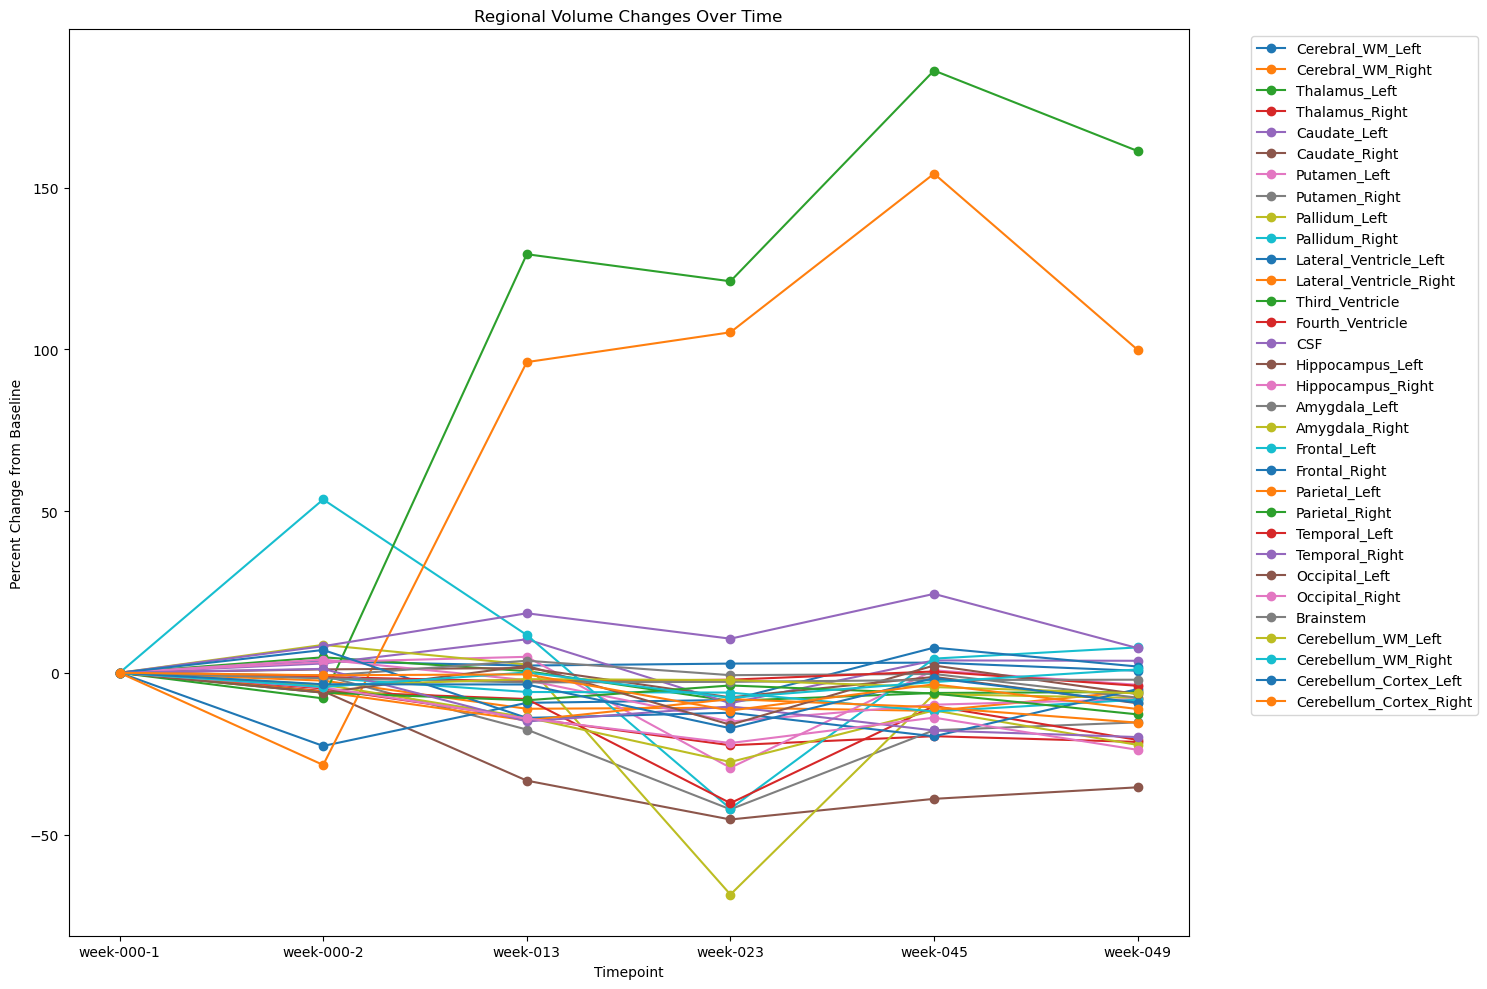

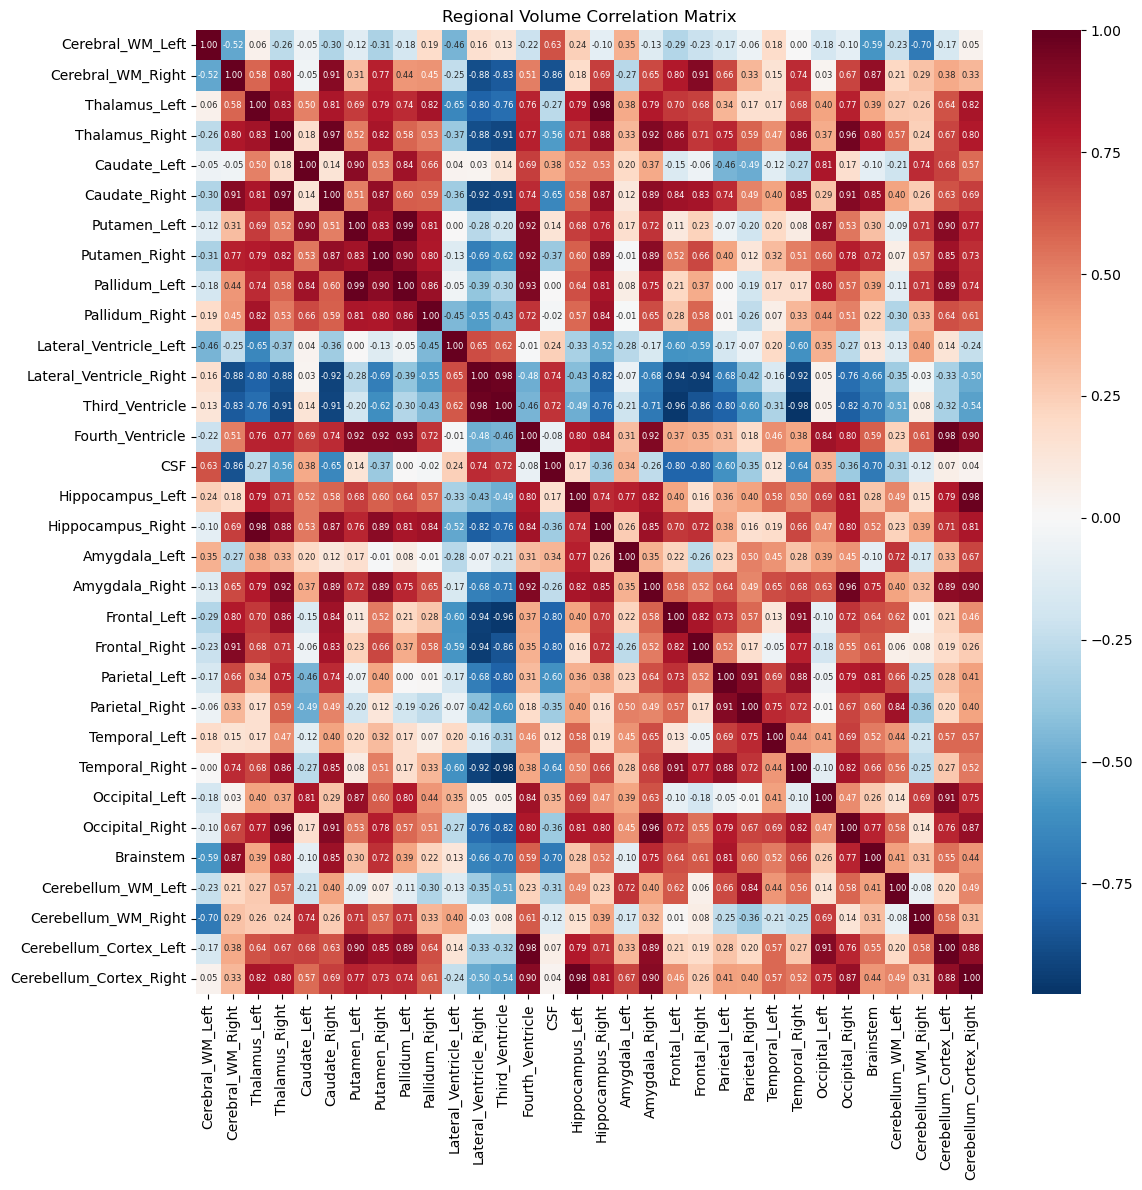

In [9]:
%%time

def main():
    """Main pipeline execution."""
    
    # Setup base directorydef main():
    """Main pipeline execution."""
    
    # Setup base directory
    base_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg"
    
    print("Setting up analysis pipeline...")
    timepoints, output_dirs = setup_glioma_analysis_pipeline(base_dir)
    
    print("Running SynthSeg analysis...")
    synthseg_results = run_synthseg_analysis(base_dir, timepoints, output_dirs)
    
    print("Analyzing regional progression...")
    region_stats, relationship_analysis = analyze_regional_progression(
        synthseg_results, timepoints, output_dirs
    )
    
    print("Creating visualizations...")
    create_visualizations(
        synthseg_results, region_stats, timepoints, output_dirs
    )
    
    print("Generating report...")
    generate_report(
        synthseg_results, region_stats, relationship_analysis, output_dirs
    )
    
    print("Copying segmentations to timepoint directories...")
    copy_synthseg_to_timepoints(base_dir, timepoints)

    print("Analysis complete!")
    return {
        'synthseg_results': synthseg_results,
        'region_stats': region_stats,
        'relationship_analysis': relationship_analysis
    }


if __name__ == "__main__":
    results = main()


_**cursor** (with claude-3.5-sonnet)_ "Please make an interpretation of the following figure: `LUMIERE-Patient-048-reg/visualizations/longitudinal_visualization.png`"

Let me help interpret this figure showing Regional Volume Changes Over Time for various brain structures:

Key Observations:

1. **Most Dramatic Changes:**
   - Lateral_Ventricle_Right shows significant expansion (up to ~150% increase by week-045)
   - Thalamus_Left also shows substantial growth (peaks around week-045)
   - These changes suggest significant mass effect and potential displacement of structures

2. **Temporal Pattern:**
   - Initial stability (week-000-1 to week-000-2)
   - Rapid changes between week-000-2 and week-013
   - Continued progression through week-045
   - Slight regression in some structures by week-049

3. **Asymmetry:**
   - Clear left-right asymmetry in several structures
   - Particularly notable in ventricles and thalamus
   - Suggests unilateral tumor growth/mass effect

4. **Structure Groups:**
   - Deep structures (thalamus, ventricles) show largest changes
   - Cortical regions show more moderate changes
   - Some structures (cerebellum, brainstem) show relative stability

5. **Clinical Implications:**
   - Pattern suggests progressive tumor growth with mass effect
   - Peak changes around week-045 followed by slight regression might indicate treatment response
   - Asymmetric changes could help localize tumor progression

This visualization effectively shows the differential impact of (likely) tumor progression on various brain regions over time, with some structures showing dramatic volume changes while others remain relatively stable.

Would you like me to elaborate on any specific aspect of this interpretation?

In [30]:
for t in tp:
    exam_dir = f"{os.path.expanduser('~')}/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/{t}"
    print(f'exam_dir: {exam_dir}')
    subjs = get_subjs(exam_dir)

exam_dir: /home/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-000-1
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /home/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-000-2
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /home/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-013
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /home/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-023
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
exam_dir: /home/arvid/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg/week-045
6 examinations:
[
'CT1.nii.gz',
'FLAIR.nii.gz',
'T1.nii.gz',
'T2.nii.gz',
'segmentation.nii.gz',
'synthseg.nii.gz',
]
e

## AD HOC visualization in Freesurfer's freeview

In [14]:
exam = tp[0]  # 'week-000-1'

In [17]:
def launch_freeview(fshome, exam, home):
    """
    Launch freeview with the specified parameters and environment setup.
    
    Args:
        fshome (str): Path to FreeSurfer home directory
        exam (str): Examination folder name (e.g., 'week-000-1')
        home (str): User's home directory
    """
    import os
    import subprocess
    
    # Store current directory
    original_dir = os.getcwd()
    
    # Set up environment variables
    env = os.environ.copy()
    env.update({
        'FREESURFER_HOME': fshome,
        'PATH': f"{fshome}/bin:{env.get('PATH', '')}",
        'SUBJECTS_DIR': f"{home}/GitHub/glioma-growth/data/LUMIERE-Patient-048-reg",
        'FSLDIR': '/usr/local/fsl'
    })
    env['PATH'] = f"{env['FSLDIR']}/bin:{env['PATH']}"
    
    # Source FreeSurfer's setup script
    setup_cmd = f"source {fshome}/SetUpFreeSurfer.sh"
    subprocess.run(setup_cmd, shell=True, executable='/bin/bash', env=env)
    
    # Source FSL's setup
    fsl_cmd = f". {env['FSLDIR']}/etc/fslconf/fsl.sh"
    subprocess.run(fsl_cmd, shell=True, executable='/bin/bash', env=env)
    
    # Change to SUBJECTS_DIR
    os.chdir(env['SUBJECTS_DIR'])
    
    # Construct freeview command
    cmd = [
        'freeview', '-v',
        f"{exam}/T1.nii.gz",
        f"{exam}/CT1.nii.gz",
        f"{exam}/T2.nii.gz",
        f"{exam}/FLAIR.nii.gz",
        f"{exam}/segmentation.nii.gz:colormap=jet:opacity=0.8",
        f"{exam}/synthseg.nii.gz:colormap=lut:opacity=0.8",
        '-ras', '24', '-2', '76'
    ]
    
    # Execute freeview without checking return code
    subprocess.run(cmd, env=env)  # Removed check=True
    
    # Return to original directory
    os.chdir(original_dir)

In [18]:
launch_freeview(fshome, exam, home)

2024-11-06 11:12:36.813 freeview[5640:137852] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-06 11:12:36.813 freeview[5640:137852] +[IMKInputSession subclass]: chose IMKInputSession_Modern
INFO: using NIfTI-1 qform 
INFO: using NIfTI-1 qform 


In [38]:
launch_freeview(fshome, tp[1], home)


INFO: using NIfTI-1 qform 
INFO: using NIfTI-1 qform 


In [41]:
launch_freeview(fshome, tp[-1], home)

INFO: using NIfTI-1 qform 
INFO: using NIfTI-1 qform 
